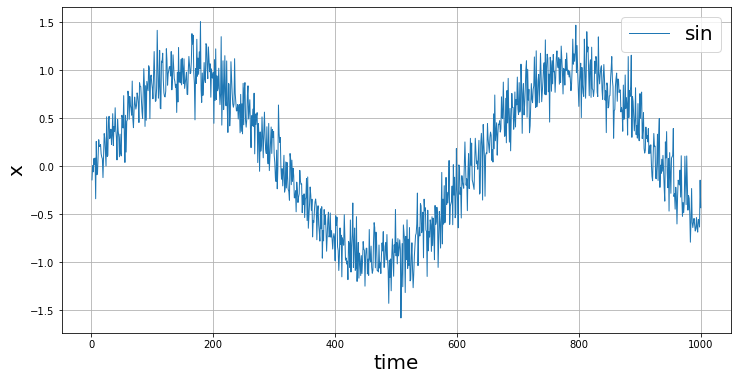

In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt

T = 1000
time = torch.arange(1,T+1,dtype=torch.float32)
x = torch.sin(0.01 * time)+torch.normal(0,0.2,(T,))
plt.figure(figsize=(12,6))
plt.plot(time,x,ls="-",lw=1,label="sin")
plt.xlabel("time",fontsize=20)
plt.ylabel("x",fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [2]:
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1,1))

batch_size, n_train = 16, 600

In [7]:
from torch.utils.data import Dataset
class myset(Dataset):
    def __init__(self,f,l,n_train):
        self.tmp = f[:n_train,:]
        self.label = l[:n_train]
        self.len = n_train
    def __getitem__(self,key):
        return self.tmp[key,:], self.label[key]
    def __len__(self,):
        return self.len
trainset=myset(features,labels,n_train)
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

In [16]:
def train(net,train_loader,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        all_loss = 0.0
        k = 0.0
        for i,data in enumerate(train_loader):
            x=data[0]
            y=data[1]
            trainer.zero_grad()
            l = loss(net(x),y)
            l.backward()
            trainer.step()

            all_loss += l.item()
            k += 1
        print(f'epoch {epoch+1},loss: {all_loss/k:f}')
net = get_net()
train(net,trainloader,loss,5,0.01)

epoch 1,loss: 0.153107
epoch 2,loss: 0.064579
epoch 3,loss: 0.061938
epoch 4,loss: 0.057895
epoch 5,loss: 0.056308


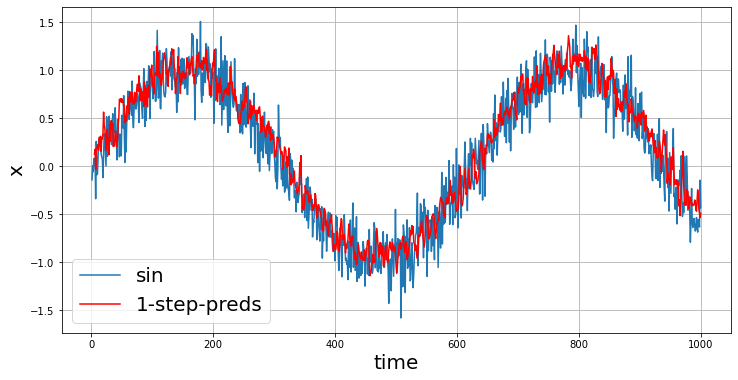

In [32]:
onestep_preds = net(features)
plt.figure(figsize=(12,6))
plt.plot(time,x,ls="-",lw=1.5,label="sin")
plt.plot(time[tau:],onestep_preds.detach().reshape((-1,)),ls="-",lw=1.5,color='r',label="1-step-preds")
plt.xlabel("time",fontsize=20)
plt.ylabel("x",fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

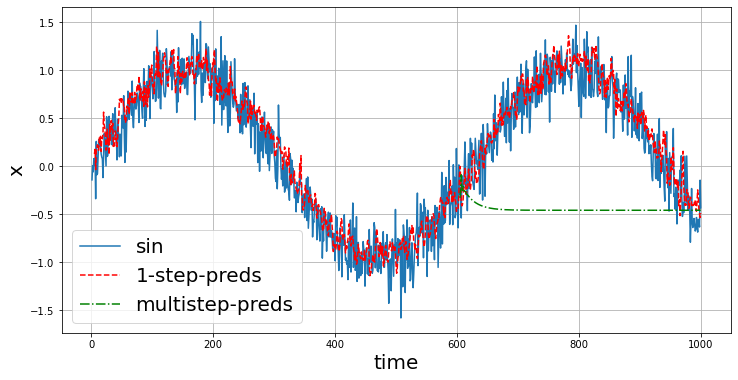

In [34]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].clone().reshape((1,-1)))
plt.figure(figsize=(12,6))
plt.plot(time,x,ls="-",lw=1.5,label="sin")
plt.plot(time[tau:],onestep_preds.detach().reshape((-1,)),ls="--",lw=1.5,color='r',label="1-step-preds")
plt.plot(time[n_train + tau:],multistep_preds.detach().reshape((-1))[n_train + tau:],ls="-.",lw=1.5,color='g',label="multistep-preds")
plt.xlabel("time",fontsize=20)
plt.ylabel("x",fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()